In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns

# Plot confusion matrices
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# NLP libraries
import re
import string
import unicodedata
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

# Evaluate the classifiers
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Import time function from time module to track the training duration
from time import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connect to database

In [2]:
# SQL Alchemy
from sqlalchemy import create_engine

In [3]:
# Create engine and connection
engine = create_engine("sqlite:///../db.sqlite")

In [4]:
# Check for tables
engine.table_names()

['cuisine_ingredients']

In [5]:
# Read in the data table
df = pd.read_sql_query('SELECT * FROM cuisine_ingredients', con=engine)

In [6]:
# Overview of the data set
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


In [7]:
# Get a list of unique cuisines in the dataset
cuisine_list = df.cuisine.unique().tolist()
cuisine_list

['African',
 'American',
 'British',
 'Caribbean',
 'Chinese',
 'East European',
 'French',
 'Greek',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Mexican',
 'Nordic',
 'North African',
 'Pakistani',
 'Portuguese',
 'South American',
 'Spanish',
 'Thai and South-East Asian',
 'Turkish and Middle Eastern']

## Define text pre-processing function

In [8]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

In [9]:
words_to_remove = [
    "tbsp", "roughly", "chopped", "tsp", "finely", "oz", "plus", "optional",
    "extra", "fresh", "freshly", "ground", "thinly", "sliced", "clove", "pint",
    "cut", "kg", "lb", "cm", "ml", "mm", "small", "large", "medium", "diced", "slice",
    "pinch", "peeled", "grated", "removed", "handful", "piece", "crushed", "red", "dried",
    "drained", "rinsed", "halved", "trimmed", "deseeded", "x", "beaten", "available", "supermarket"]

In [10]:
# Create a function to clean ingredient text
def clean(doc):
    doc = doc.str.lower()
    doc = doc.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')
    doc = doc.str.translate(str.maketrans('', '', string.punctuation))
    doc = doc.str.replace(r'[£×–‘’“”⁄]', '')
    doc = doc.apply(lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))
    doc = doc.apply(lambda x: word_tokenize(x))
    doc = doc.apply(lambda x: [word for word in x if not word in stop_words_nltk])
    doc = doc.apply(lambda x: [word for word in x if not word in words_to_remove])
    doc = doc.apply(lambda x: [stemmer.stem(word) for word in x])
    processed_doc = doc.apply(lambda x: ' '.join([word for word in x]))

    return processed_doc

In [11]:
# Add a new column to the dataframe with the cleaned text
df["ingredients_processed"] = clean(df.full_ingredients)

In [12]:
# Overview of the dataset
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients,ingredients_processed
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ...",oliv oil shallow deep fri shallot garlic chill...
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie...",groundnut oil long chilli sichuan peppercorn w...
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri...",sunflow oil rasher thick rindless smoke streak...
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1...",butter jumbo oat roll oat onion pistachio fig ...
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e...",flour freerang egg prefer bright yellow yolk f...
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in...",flouri potato cube rasher smoke streaki bacon ...
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small...",greekstyl yoghurt onion garlic ginger garam ma...
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz...",yellow split pea butter onion thyme bay leaf s...
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a...",beef shin bone sea salt black pepper oliv oil ...
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int...",celeriac thin matchstick see tip lemon juic li...


## Modeling

### Split the data into training and test sets (75% train and 25% test)

In [13]:
# The column contains textual data to extract features from.
X = df.ingredients_processed

# The column we're learning to predict.
y = df.cuisine
print(X.shape, y.shape)

(4724,) (4724,)


In [14]:
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3543,) (3543,)
(1181,) (1181,)


### Resampling

In [15]:
# Concatenate our training data back together
X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_train.shape

(3543, 2)

In [16]:
# Overview of the training set
X_y_train.head()

,ingredients_processed,cuisine
1948,white fish fillet sole plaic cornflour dust gr...,Chinese
921,oliv oil goodqual pork sausag shallot rosemari...,British
4215,veget oil onion garlic root ginger tomato chil...,Pakistani
2601,sirloin steak salt black pepper oliv oil butte...,French
3770,type pasta flour bake section deli dust salt b...,Italian


In [17]:
# Separate minority and majority classes
british_cuisines_df = X_y_train[X_y_train.cuisine=="British"]
other_cuisines_df = X_y_train[X_y_train.cuisine!="British"]
other_cuisines_df.head()

,ingredients_processed,cuisine
1948,white fish fillet sole plaic cornflour dust gr...,Chinese
4215,veget oil onion garlic root ginger tomato chil...,Pakistani
2601,sirloin steak salt black pepper oliv oil butte...,French
3770,type pasta flour bake section deli dust salt b...,Italian
3737,tagliatel broccoli floret hand pea frozen oliv...,Italian


In [18]:
# Get a list of minority cuisines
other_cuisines = other_cuisines_df.cuisine.unique().tolist()
other_cuisines

['Chinese',
 'Pakistani',
 'French',
 'Italian',
 'Japanese',
 'Indian',
 'Mexican',
 'American',
 'Nordic',
 'Turkish and Middle Eastern',
 'Caribbean',
 'Thai and South-East Asian',
 'North African',
 'East European',
 'Irish',
 'Portuguese',
 'Greek',
 'South American',
 'Spanish',
 'Korean',
 'African']

In [19]:
other_cuisines_upsampled = list()

# Upsample the minorities

for cuisine in other_cuisines:
    cuisine_df = X_y_train[X_y_train.cuisine==cuisine]
    cuisine_upsampled = resample(cuisine_df,
                                 replace=True, # sample with replacement
                                 n_samples=len(british_cuisines_df), # match number of recipes in British cuisine
                                 random_state=1)
    other_cuisines_upsampled.append(cuisine_upsampled)

In [20]:
# Create a new resampled data set for minority cuisines
other_cuisines_upsampled = pd.concat(other_cuisines_upsampled)
other_cuisines_upsampled.head()

,ingredients_processed,cuisine
1909,veget oil shallow fri firm tofu pat dri kitche...,Chinese
2041,firm white fish fillet cod sole skin whole fis...,Chinese
2019,shaox rice wine dri sherri light soy sauc clea...,Chinese
1980,lobster sesam oil root ginger spring onion pak...,Chinese
1999,pork minc ginger garlic spring onion soy sauc ...,Chinese


In [21]:
# Combine the majority and the upsampled minority
upsampled = pd.concat([british_cuisines_df, other_cuisines_upsampled])

In [22]:
# check new class counts
upsampled.cuisine.value_counts()

British                       1098
North African                 1098
Turkish and Middle Eastern    1098
Korean                        1098
Portuguese                    1098
Irish                         1098
Thai and South-East Asian     1098
Italian                       1098
Chinese                       1098
Greek                         1098
African                       1098
Caribbean                     1098
Pakistani                     1098
Indian                        1098
Nordic                        1098
East European                 1098
Spanish                       1098
Mexican                       1098
American                      1098
French                        1098
South American                1098
Japanese                      1098
Name: cuisine, dtype: int64

In [23]:
# Overview of the upsampled dataset
upsampled.sample(10, random_state=2)

,ingredients_processed,cuisine
4133,oliv oil fri chicken thigh onion garlic clove ...,North African
3773,flour freerang italian yellow golden egg durum...,Italian
2592,salt butter room temperatur caster sugar star ...,French
4159,chicken joint piec oliv oil preserv lemon wash...,North African
4204,ghee clarifi butter onion root ginger garlic c...,Pakistani
3943,fillet beef garlic clove root ginger slice oni...,Korean
4287,whole king prawn around oliv oil garlic clove ...,Spanish
4046,oliv oil greas beef minc onion garlic clove ch...,Mexican
2145,salmon fillet skin longgrain rice butter greas...,East European
4413,duck breast skin veget oil dark soy sauc clear...,Thai and South-East Asian


### Feature engineering using TF-IDF with n-grams

In bag of words and bag of n-grams approaches, all words in a corpus are treated equally important. TF-IDF, meanwhile, emphasizes that some words in a document are more important than others. This time, I'll try TF-IDF with unigram.

In [24]:
X_train_new = upsampled.ingredients_processed
y_train_new = upsampled.cuisine

In [25]:
tfidf = TfidfVectorizer()

In [26]:
X_train_transformed = tfidf.fit_transform(X_train_new)
print(X_train_transformed.shape)

(24156, 2874)


### Train the model

In [27]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')

In [28]:
# Train the classifier and time the training step
%time model.fit(X_train_transformed, y_train_new)

Wall time: 19.9 s


SVC(kernel='linear')

In [29]:
# Make class predictions for X_test_transformed
X_test_transformed = tfidf.transform(X_test)
y_predicted = model.predict(X_test_transformed)
y_predicted

array(['Italian', 'French', 'British', ..., 'American', 'British',
       'Italian'], dtype=object)

 ### Evaluate the model using accuracy, confusion matrix, and classification report

In [30]:
# Use a Dummy Classifer to classify cuisines without even training a "real" model
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier().fit(X_train_transformed, y_train_new)
dummy_pred = dummy.predict(X_test_transformed)

# Check accuracy on test set
print('Dummy Classifer Test Accuracy: ', accuracy_score(y_test, dummy_pred))

Dummy Classifer Test Accuracy:  0.04911092294665537


C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [31]:
# Print accuracy on test set:
print("Test Accuracy: ", accuracy_score(y_test, y_predicted))

Test Accuracy:  0.6883996613039797


> Accuracy is not the best metric to evaluate imbalanced testing datasets as it can be very misleading. I'll use confusion matrix and classification report for further understanding about the model performance.

In [32]:
# Function to plot confusion matrix. 
# Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

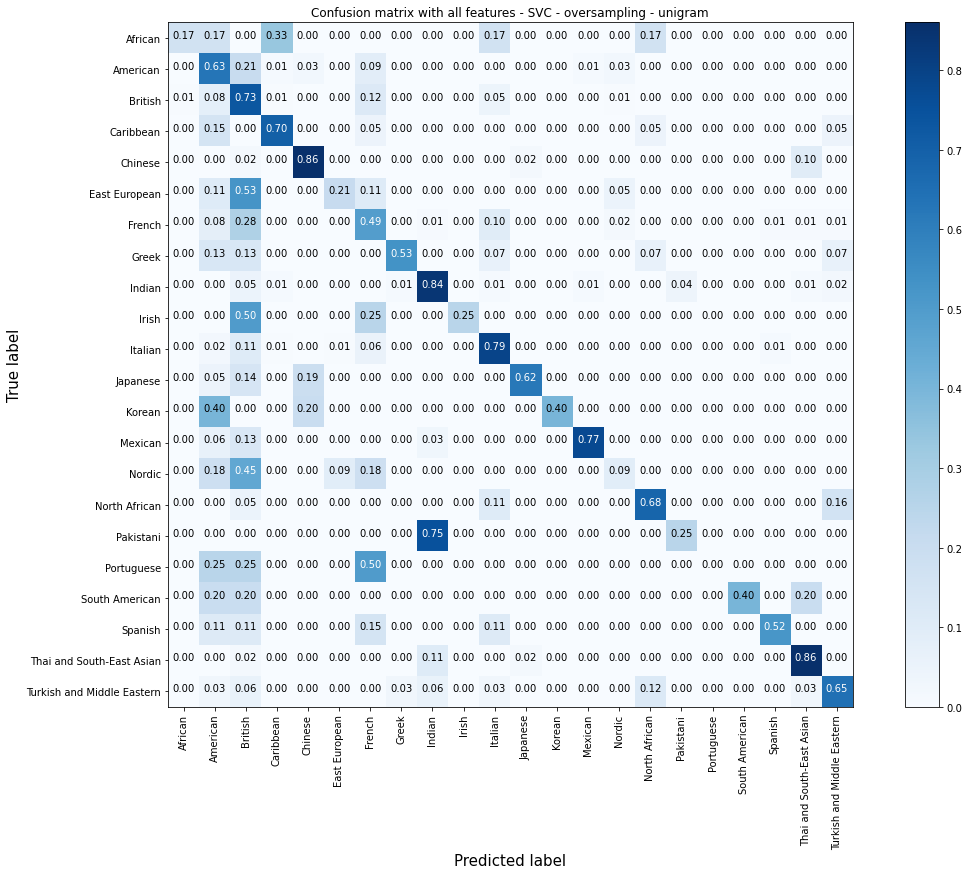

In [33]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=cuisine_list, normalize=True,
                      title='Confusion matrix with all features - SVC - oversampling - unigram')
plt.savefig("../static/images/cfm_svc_oversampling_uni.png", bbox_inches='tight')

This time the model performs quite similarly to the previous SVC model using both uni and bigrams (69% vs. 70% respectively). It also scores quite better than the NB model with unigram, with 69% vs. 64% overall accuracy score respectively. Like NB model using unigram, it predicts very well in Chinese, Indian, Mexican, Thai and South-East Asian cuisines. It misses out completely on Portuguese cuisine, and scores very low on Nordic cuisine. A closer look suggests that it does much better than the NB model with unigram in identifying dominant labels like British and Italian cuisines. This can explain the higher overall score of the model. The SVC model with unigram does better than the NB model with unigram in some labels and vice versa.

In [34]:
# Calculate classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted,
                            target_names=cuisine_list))

                            precision    recall  f1-score   support

                   African       0.33      0.17      0.22         6
                  American       0.43      0.63      0.51        78
                   British       0.71      0.73      0.72       366
                 Caribbean       0.67      0.70      0.68        20
                   Chinese       0.86      0.86      0.86        50
             East European       0.57      0.21      0.31        19
                    French       0.45      0.49      0.47       122
                     Greek       0.80      0.53      0.64        15
                    Indian       0.84      0.84      0.84        98
                     Irish       0.67      0.25      0.36         8
                   Italian       0.79      0.79      0.79       178
                  Japanese       0.87      0.62      0.72        21
                    Korean       1.00      0.40      0.57         5
                   Mexican       0.92      0.77

C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluate the model using k-fold cross validation

In [35]:
new_tfidf = TfidfVectorizer()

In [36]:
# The column contains textual data to extract features from.
X = df.ingredients_processed
X_transformed = new_tfidf.fit_transform(X)

# The column we're learning to predict.
y = df.cuisine 
print(X.shape, y.shape)

(4724,) (4724,)


In [37]:
# Create 10 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [38]:
# Train and evaluate multiple train_test combinations using kfolds
results = cross_val_score(model, X_transformed, y, cv=kfold)
print(results)
print("Accuracy Score Mean:", results.mean())
print("Accuracy Score Std:", results.std())

[0.71247357 0.69978858 0.68710359 0.69133192 0.68220339 0.69915254
 0.69491525 0.71610169 0.68008475 0.72033898]
Accuracy Score Mean: 0.6983494284588097
Accuracy Score Std: 0.013351748961106732


Comparing the average accuracy score of NB model with unigram, SVC model with unigram and bigrams, and SVC model with unigram, the SVC model with unigram seems to perform the best at 69.8% accuracy. Taking into account the previous analyses and because I'm not particularly interested in any specific cuisine, I'll select the SVC model with unigram.

### Hyperparameter Tuning

Use GridSearchCV to tune the model's hyperparameters

In [39]:
# # Create the GridSearch estimator along with a parameter object containing the values to adjust
# from sklearn.model_selection import GridSearchCV
# param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}
# grid = GridSearchCV(model, param_grid, verbose=3)

In [40]:
# Train the model with GridSearch

In [41]:
# print(grid2.best_params_)
# print(grid2.best_score_)

### Test model on one example

In [42]:
text = "butter, for greasing \
        400ml/14fl oz full-fat milk \
        50g/1¾oz fresh white breadcrumbs \
        4 large free-range eggs, beaten \
        1 tbsp olive oil \
        1kg/2lb 4oz lamb mince \
        2 onions, finely chopped \
        1 bay leaf \
        2 garlic cloves, crushed \
        2 tbsp madras curry paste \
        250ml/9fl oz lamb stock \
        2 tbsp Worcestershire sauce \
        2 tbsp mango chutney \
        50g/1¾oz raisins \
        50g/1¾oz dried apricots, chopped \
        1 tbsp cider vinegar"

In [43]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[£×–‘’“”⁄]', '', text)
    text = re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, text)
    words = word_tokenize(text)
    words = [word for word in words if not word in stop_words_nltk]
    words = [word for word in words if not word in words_to_remove]
    stemmed_words = [stemmer.stem(word) for word in words ]
    processed_text = ' '.join([word for word in stemmed_words])
    
    return processed_text

In [44]:
X_cleaned = pd.Series([preprocess(text)])
X_cleaned

0    butter greas fullfat milk white breadcrumb fre...
dtype: object

In [45]:
result = model.predict(tfidf.transform(X_cleaned))
result

array(['African'], dtype=object)